# Introduksjon til Pytorch

Pytorch, eller torch er et open source framework for maskinlæring. Det er ett av de mest brukte rammeverkene, sammen med noen alternativer som TensorFlow eller Keras. Pytorch hovedfokus er brukervennlighet. Dette gjør det velegnet til testing og eksperimentering, fordi det er svært enklet å bygge, endre på og kjøre modeller. Det er også veldig "pythonsk"  i sin implementering, som gjøre det intuitivt å jobbe med og debugge for de som er vant til å bruke python.

Denne notebooken er en veldig kort intro til de aller viktigste elementene i pytorch. Den er likevel på ingen måte dekkende for alt som ligger i rammerverket, så det kan være veldig nyttig å sjekke ut dokumentasjonen og flere av tutorialene som er tilgjengelig på https://pytorch.org/.

### En intro til tensorer

*Tensoren* er grunnpilaren i pytorch, og er datatypen som brukes til å holde alt av torch-data. I praksis ligner det mye på en numpy-array, i at det er en mangedimensjonal kontainer som kan holde på mange typer tall, men den har en del tilleggs-features.

En tensor kan opprettes på mange måter:

In [1]:
import torch

In [3]:
# fra en liste med tall
a = torch.tensor([1,2,3])

a

tensor([1, 2, 3])

In [4]:
# en tensor fylt med 0-er
b = torch.zeros(4)

b

tensor([0., 0., 0., 0.])

In [6]:
# flere dimensjoner
c = torch.zeros(3,4)

c

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [9]:
# en tom tensor 
d = torch.empty(0)

d

tensor([])

In [10]:
# fra en numpy array
import numpy as np
arr = np.array([3,4,5])

f = torch.from_numpy(arr)
f

tensor([3, 4, 5], dtype=torch.int32)

### Integrasjon opp mot cuda

Et vikitig element med tensorer er hvordan de lett kan flyttes over på GPU med cuda, noe som er helt sentalt for effektiv trening av maskinlæringsmodeller.

Plasseringen til en tensor kan man finne under `device` og den kan enkelt flyttes med `to` metoden.

In [11]:
torch.cuda.is_available()

False

In [12]:
f.device

device(type='cpu')

In [14]:
f.to("cpu") #cuda / cuda:n

f.device

device(type='cpu')

### Vanlige tensor-operasjoner

På samme måte som numpy arrays er tensorer vektorisert, og takler å gjøre de fleste regneoperasjoner på tensoren som helhet, uten at man trenger å løkke gjennom enkelttall. Boolsker operasjoner og indeksering fungerer også på mer eller mindre samme måte.

In [15]:
a = torch.tensor([2,4,-6])
b = torch.tensor([1,-1,0])

In [16]:
a+b

tensor([ 3,  3, -6])

In [17]:
a*b

tensor([ 2, -4,  0])

In [18]:
b/a

tensor([ 0.5000, -0.2500, -0.0000])

In [19]:
a == 2

tensor([ True, False, False])

In [20]:
a < 0

tensor([False, False,  True])

In [22]:
a[0]

tensor(2)

In [23]:
b[1:]

tensor([-1,  0])

In [21]:
a[b>=0]

tensor([ 2, -6])

### Torchvision

Torchvision er en pakke distribuert av torch, som inneholder mange populære datasett og modeller, i utrent eller pretrent format. Disse kan være veldig nyttige for å ha for eksperimentering, læring, eller som et startpunkt for videreutvikling og videretrening.

Som et eksempel kan vi laste ned datasettet [Eurosat](https://pytorch.org/vision/main/generated/torchvision.datasets.EuroSAT.html)

In [21]:
# en url autoriseringsfix som kan være nødvendig
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# last ned Eurosat til /data/
import torchvision
data = torchvision.datasets.EuroSAT(root='./data',download=True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting ./data\eurosat\EuroSAT.zip to ./data\eurosat


### Dataloaders

Torch inneholder også funksjonalitet for enkelt å laste inn datasettet man skal trene på i riktige batch størrelser og med riktig preprosessering.

Vi kan lage en dataloader for Eurosat.

In [30]:
import torchvision.transforms as transforms

# sett en transform for datasettet
data.transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# split i trening og test
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data,test_size=0.2,stratify=data.targets)


In [31]:
# lag en loader med batch size 4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)


In [34]:
# test ved å vise frem en batch med bilder
import matplotlib.pyplot as plt
import numpy as np
classes = ('Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway',
           'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea/Lake')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)

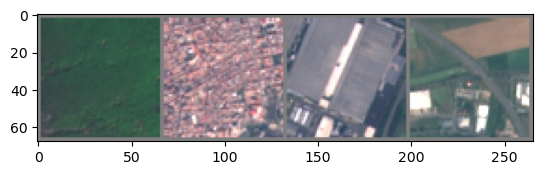

Forest Residential Industrial Highway


In [37]:
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

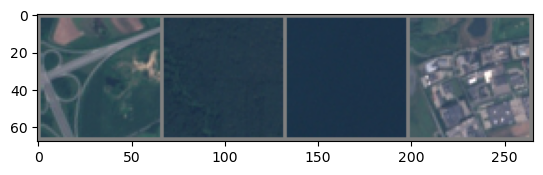

Highway Forest Sea/Lake Industrial


In [41]:
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Nevrale nettverk

Torch er bygget for å enklet kunne sette sammen komponenter til et nevralt nettverk. Disse ligger stort sett i submodulen `torch.nn`.

In [1]:
import torch.nn  as nn

Eksempelvis kan vi sette sammen to konvolusjonslag med kernel 3x3 og ReLU aktivering og ett lite lineært lag til et mini nett som tar inn bilder av strørrelse 32x32 piksler.

In [14]:
class miniNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
                        nn.Conv2d(3,8,3),
                        nn.ReLU(),
                        nn.Conv2d(8,8,3),
                        nn.ReLU(),
                        )
        self.linear = nn.Linear(28*28*8,1)
    
    def forward(self,x):
        x = self.conv_block(x)
        x = x.flatten()
        x = self.linear(x)
        return x

net = miniNet()



In [15]:
net

miniNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Linear(in_features=6272, out_features=1, bias=True)
)

In [19]:
from torchinfo import summary

summary(net,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
miniNet                                  [1]                       --
├─Sequential: 1-1                        [1, 8, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 8, 30, 30]            224
│    └─ReLU: 2-2                         [1, 8, 30, 30]            --
│    └─Conv2d: 2-3                       [1, 8, 28, 28]            584
│    └─ReLU: 2-4                         [1, 8, 28, 28]            --
├─Linear: 1-2                            [1]                       6,273
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
Total mult-adds (M): 0.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.03
Estimated Total Size (MB): 0.15

For å trene et nettverk i pytorch må man velge seg et optimeringsmetode og gjøre backpropagation i en treningsloop. Les mer om dette her: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html